# Parameters of tracklets

In this notebook, we try to estimate several parameters of tracklets: the rotation period of tracklets around the Earth, the inclination of orbits, the size of objects, ...

In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

import pandas as pd
import numpy as np
import glob
import os

from tqdm.auto import tqdm

from astropy.table import Table, vstack
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import AltAz
from astropy.coordinates import EarthLocation
from astropy.constants import R_earth

from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.wcs import WCS

from astropy.coordinates import SkyCoord, concatenate, get_sun
from fastparquet import ParquetFile
from tracklet_utils import get_velocity_bystep, get_inclination_bystep
from tracklet_utils import apparent_to_absolute, get_class_from_period
from tracklet_utils import fake_lambertian_size, fake_lambertian_size_apparent
from tracklet_utils import get_semi_major_axis, get_semi_major_axis_from_mu

from fink_science.conversion import dc_mag

/Users/julien/anaconda3/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


## Loading tracklet data

We load tracklet data from the previous step

In [3]:
# change for different dates
basepath = '*_consolidated/'

filenames = glob.glob(os.path.join(basepath, 'tracklets.parquet'))

for index, filename in enumerate(filenames):
    pdf_ = pd.read_parquet(filename)
    print('{} : {} tracklets'.format(filename, len(pdf_)))
    if index == 0:
        pdf = pdf_
    else:
        pdf = pd.concat((pdf, pdf_))
data = Table.from_pandas(pdf)
print('Total number of tracklets: {}'.format(len(data)))

ufo_fink_2021_consolidated/tracklets.parquet : 6648 tracklets
ufo_fink_2020_consolidated/tracklets.parquet : 14626 tracklets
ufo_fink_2021_may_consolidated/tracklets.parquet : 40 tracklets
ufo_fink_2019_consolidated/tracklets.parquet : 1154 tracklets
Total number of tracklets: 22468


## Rotation period

todo: explain the relation between velocity and period (Kepler).


Loop over nights, and over tracklets to extract the velocity (and other parameters). Note we require a minimum number of 3 alerts per exposure within a tracklet (and the tracklet needs at least 5 alerts):

In [4]:
vels = []

# Loop over nights
for n in np.unique(data['nid']):
    maskNight = data['nid'] == n
    
    # Loop over tracklets inside a night
    for k in np.unique(data[maskNight]['tracklet_number']):
        maskTracklet = data['tracklet_number'] == k
        mask = maskTracklet * maskNight

        # Extract velocity
        vel = get_velocity_bystep(
            data[mask], 
            single_exposure_time=30., 
            min_alert_per_exposure=3
        )
        if vel != 0.0:
            vels.append(vel)
        else:
            vels.append(np.nan)

# Remove pathological values
maskFinite = np.isfinite(vels)
vels = np.array(vels)[maskFinite]

Text(0.5, 1.0, 'period = 360 [deg] / distance [deg] * $t_{exposure}$[hours]')

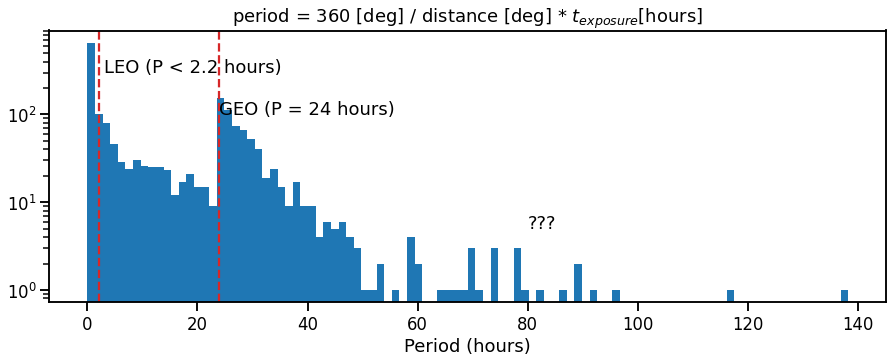

In [5]:
periods = 360. / np.array(vels)

fig = plt.figure(figsize=(15, 5))
plt.hist(periods, bins=100)

plt.axvline(2.2, ls='--', color='C3')
plt.axvline(24, ls='--', color='C3')

plt.text(3, 300, 'LEO (P < 2.2 hours)')
plt.text(24, 100, 'GEO (P = 24 hours)')
plt.text(80, 5, '???')

plt.yscale('log')
# plt.xlim(0, None)
plt.xlabel('Period (hours)')
plt.title(r'period = 360 [deg] / distance [deg] * $t_{exposure}$[hours]')

In [6]:
classes = np.array([get_class_from_period(period) for period in periods])

print('Distribution of classes:')
print('- LEO: {:.2f} %'.format(np.sum(classes == 'LEO')/len(classes) * 100))
print('- MEO: {:.2f} %'.format(np.sum(classes == 'MEO')/len(classes) * 100))
print('- GEO: {:.2f} %'.format(np.sum(classes == 'GEO')/len(classes) * 100))
print('- Unknown: {:.2f} %'.format(np.sum(classes == 'Unknown')/len(classes) * 100))

Distribution of classes:
- LEO: 39.32 %
- MEO: 24.13 %
- GEO: 9.33 %
- Unknown: 27.22 %


## Characteristic length estimation

Let's try to estimate the characteristic length of objects, $L_c$. Assuming the object is a Lambertian sphere, we have:

$L_c = 10^{(m_{sun} - m_{app})/5} \dfrac{R}{\sqrt{A}}\sqrt{\dfrac{6\pi}{\sin{\phi} + (\pi - \phi)\cos{\phi}}}$ 

where $m_{sun}$ is the apparent magnitude of the Sun, $m_{app}$ is the apparent magnitude of the object, $R$ is the distance object-Earth, $\phi$ is the solar phase angle, and $A$ is the albedo. For the albedo, we will assume $A=0.175$ (from https://arxiv.org/abs/2012.12549). The distance $R$ can be infered from the rotation period $P$ using:

$P = 2 \pi \sqrt{\dfrac{a^3}{\mu}}$

where $a$ is the semi-major axis, and $\mu$ the gravitational parameter ($3.986\times10^5$ km$^3$/s$^2$for Earth). In practice, there is a miminum semi-major axis for the orbit as objects fly above Earth surface. If we write $a = R_e + h$, where $R_e$ is the Earth radius, and $h$ the altitude, we have $a_{min} \approx R_e + 200$km. This will set a minimum rotation period to consider in this exercise:

$P_{min} = 2 \pi \sqrt{\dfrac{a_{min}^3}{\mu}}$

We will discard $P < P_{min}$ (objects are likely to not follow great circles actually).


In [7]:
magabs = []
magapp = []
sun_dists = []

sizes = []
distances = []
altitudes = []

inclination = []


# Loop over nights
for n in np.unique(data['nid']):
    maskNight = data['nid'] == n
    
    # Loop over tracklets inside a night
    for k in np.unique(data[maskNight]['tracklet_number']):
        maskTracklet = data['tracklet_number'] == k
        mask = maskTracklet * maskNight
        
        # Extract absolute magnitude
        mag, err = np.array(
            [
                dc_mag(*i) for i in zip(
                    data[mask]['fid'],
                    data[mask]['magpsf'],
                    data[mask]['sigmapsf'],
                    data[mask]['magnr'],
                    data[mask]['sigmagnr'],
                    data[mask]['magzpsci'],
                    data[mask]['isdiffpos'],
                )
            ]
        ).T

        magabs_, sun_dists_ = apparent_to_absolute(
            mag, 
            data['jd'][mask],
            data['ra'][mask],
            data['dec'][mask],
        )
        
        # compute Elevation/azimuth
        coords_radec = SkyCoord(data['ra'][mask], data['dec'][mask], unit='deg')
        t_iso = Time(data['jd'][mask], format='jd')
        aa = AltAz(location=EarthLocation.of_site('Palomar'), obstime=t_iso)

        # cosine of the zenith angle
        cos_el = np.cos(np.pi / 2. - coords_radec.transform_to(aa).alt.rad)

        # lazily Re-extract velocity
        vel = get_velocity_bystep(
            data[mask], 
            single_exposure_time=30., 
            min_alert_per_exposure=3
        )
        # a = R_earth + h, h=altitude
        if (vel != 0.0) and np.isfinite(vel):
            altitudes_ = (get_semi_major_axis(360. / vel) - R_earth.value/1000.)
        else:
            altitudes_ = np.nan

        # observer-object distance
        distances_ =  altitudes_ / cos_el

        # remove unphysical distances
        distances_[distances_ < 200] = np.nan

        # compute object size
        sizes_ = fake_lambertian_size_apparent(
            mag, -26.7, distances_, sun_dists_, 0.175
        )*1000
        
        # extract inclination for after
        if np.isfinite(np.median(distances_)):
            mean_inclination, err_inclination = get_inclination_bystep(
                data[mask], 
                distances_,
                single_exposure_time = 30., 
                min_alert_per_exposure = 3
            )
            inclination.append(mean_inclination)
        else:
            inclination.append(np.nan)
        
        sizes.append(np.median(sizes_))
        distances.append(np.median(distances_))
        altitudes.append(altitudes_)
        
        magabs.append(magabs_)
        magapp.append(mag)
        sun_dists.append(sun_dists_)

# Remove pathological values
magabs = np.array(magabs)[maskFinite]
magapp = np.array(magapp)[maskFinite]
sun_dists = np.array(sun_dists)[maskFinite]
sizes = np.array(sizes)[maskFinite]
distances = np.array(distances)[maskFinite]
altitudes = np.array(altitudes)[maskFinite]
inclination = np.array(inclination)[maskFinite]

/Users/julien/Documents/workspace/myrepos/tracklets/tracklet_utils.py:271: RuntimeWarning: invalid value encountered in double_scalars
  vx = (x2 - x1) / dt
/Users/julien/Documents/workspace/myrepos/tracklets/tracklet_utils.py:272: RuntimeWarning: invalid value encountered in double_scalars
  vy = (y2 - y1) / dt
/Users/julien/Documents/workspace/myrepos/tracklets/tracklet_utils.py:273: RuntimeWarning: invalid value encountered in double_scalars
  vz = (z2 - z1) / dt
/Users/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lis


min: 0.001071286018986564
median: 0.7243449906013852
mean: 1.196423219091981
max: 78.59307487095583



Text(0.5, 0, 'Characteristic length $L_c$ [meter]')

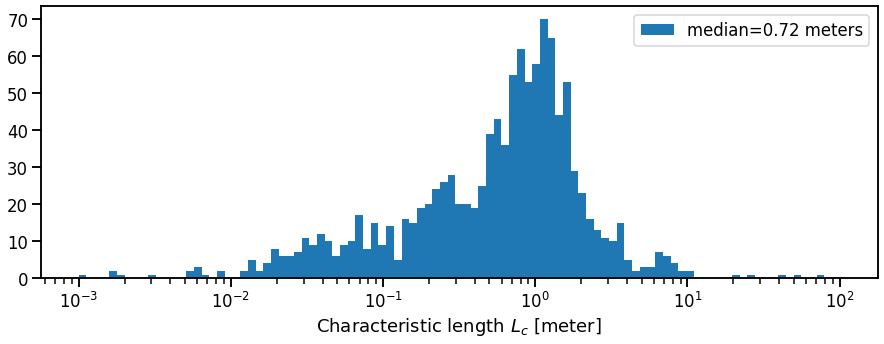

In [8]:
mask = np.isfinite(sizes) #* (sizes < 10)

fig = plt.figure(figsize=(15, 5))

bins = np.logspace(-3, 2, 100)
plt.hist(sizes[mask], bins=bins, label='median={:.2f} meters'.format(np.median(sizes[mask])))

msg = """
min: {}
median: {}
mean: {}
max: {}
""".format(
    np.min(sizes[mask]),
    np.median(sizes[mask]),
    np.mean(sizes[mask]),
    np.max(sizes[mask])
)
print(msg)


plt.xscale('log')
plt.legend()
plt.xlabel(r'Characteristic length $L_c$ [meter]')

Object sizes peaked around 72 cm. We have a tail down to the cm scale, and some objects with large size (meter scale)

Text(0.5, 1.0, 'Angular sizes of tracklet objects')

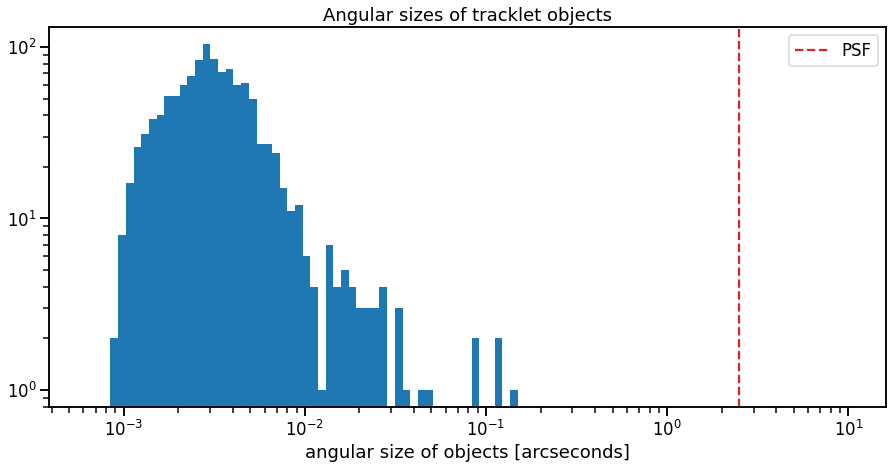

In [9]:
fig = plt.figure(figsize=(15, 7))

mask = np.isfinite(sizes)

bins = np.logspace(-3.2, 1, 100)
plt.hist(sizes[mask]/1000./distances[mask] * 3600. / np.pi * 180., bins=bins);
plt.axvline(2.5, ls='--', color='C3', label='PSF')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('angular size of objects [arcseconds]')
plt.title('Angular sizes of tracklet objects')

Object sizes are way below the PSF scale

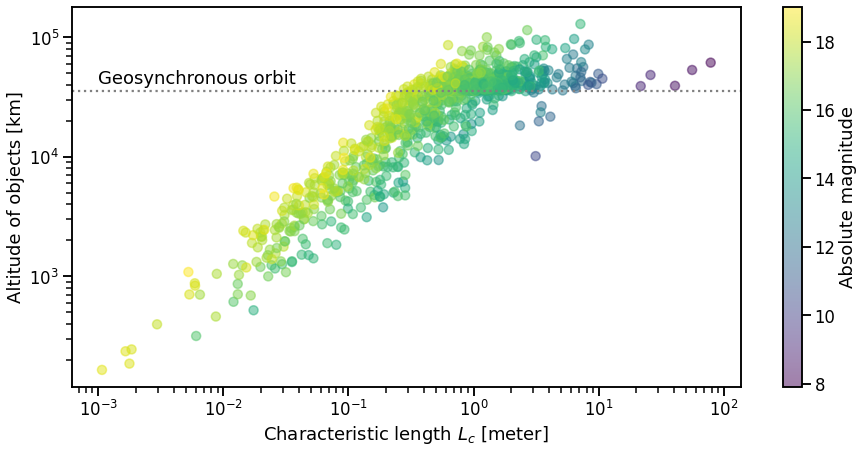

In [10]:
fig = plt.figure(figsize=(15, 7))

mask2 = np.isfinite(sizes)

plt.scatter(
    sizes[mask2], 
    altitudes[mask2], 
    marker='o', 
    c=np.array([np.median(i) for i in magabs])[mask2], 
    alpha=0.5
)
plt.xlabel(r'Characteristic length $L_c$ [meter]')
plt.ylabel(r'Altitude of objects [km]')
plt.axhline(42164 - R_earth.value/1000., ls=':', color='grey')
plt.colorbar().set_label('Absolute magnitude')

plt.text(0.001, 4.5 * 1e4, 'Geosynchronous orbit', va='center')
plt.xscale('log')
plt.yscale('log')

- smaller objects move in smaller orbits to be detectable (mag apparent max for ZTF ~ 21).
- One can not see big objects on small orbits: if there were, they were probably very bright such that they left tracks that were removed prior generating alerts (as is done for known satellites).
- One can see a color gradient along the x-axis: at a given orbit, smaller objects are fainter.
- One can see a break at geostationary orbit: object orbits are bounded.
- One can see a small, but not very significant gradient along the y-axis: objects of the same size should have the same absolute magnitude if they are of the same kind. If their magnitudes vary this means they are made of different materials, or have different shapes.
- One can see object sizes beyond 10 meters. You should probably not consider them, as the hypotheses used to compute quantities are probably not valid for those, leading to these outlier values.

##  Inclination of orbits

TODO: explain how inclination is computed

Text(0.5, 0, 'inclination [degree]')

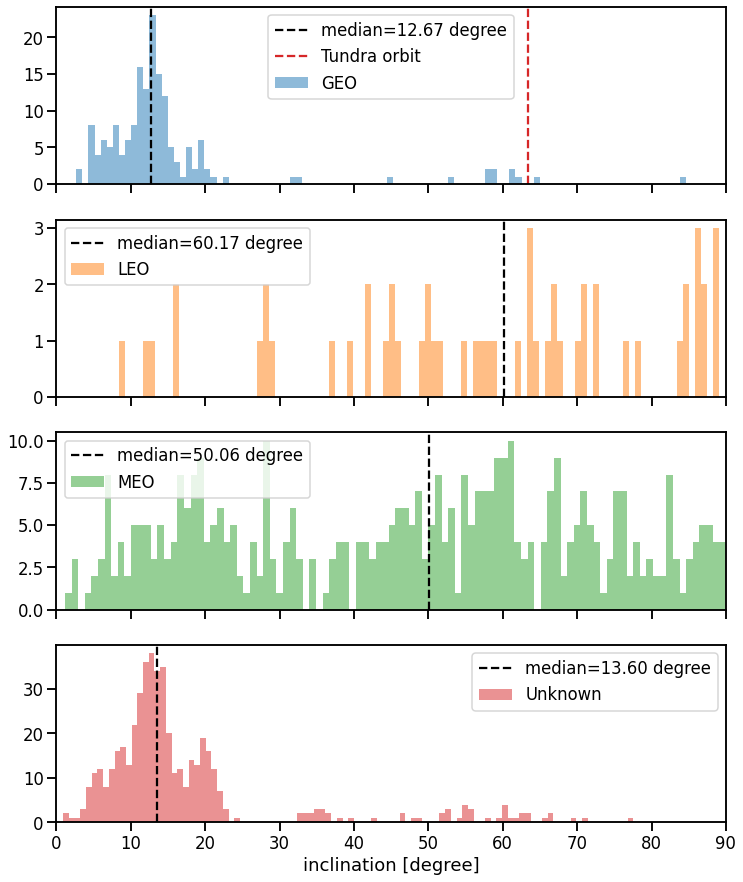

In [11]:
mask = np.isfinite(inclination)

fig, ax  = plt.subplots(len(np.unique(classes)), 1, figsize=(12, 15), sharex=True)

for index, class_ in enumerate(np.unique(classes)):
    m = classes[mask] == class_
    ax[index].hist(inclination[mask][m], bins=100, label=class_, alpha=0.5, color='C{}'.format(index))
    median_ = np.median(inclination[mask][m])
    ax[index].axvline(median_, ls='--', color='black', label='median={:.2f} degree'.format(median_))
    if class_ == 'GEO':
        ax[index].axvline(63.4, ls='--', color='C3', label='Tundra orbit')
    
#     msg = """
#     Class {}
#     min: {}
#     median: {}
#     mean: {}
#     max: {}
#     """.format(
#         class_,
#         np.min(inclination[mask][m]),
#         np.median(inclination[mask][m]),
#         np.mean(inclination[mask][m]),
#         np.max(inclination[mask][m])
#     )
#     print(msg)

    ax[index].legend()
# plt.xscale('log')
plt.xlim(0, 90)
plt.xlabel(r'inclination [degree]')

Note that inclination is usually distributed between 0 and 180 degree, with [0, 90] being direct orbits, and [90, 180] being indirect orbits. Unfortunately, we do not have the direction of motion for tracklets (they are mostly derived from single exposure), so we force the inclination to lie in the [0, 90] quadrant.

As expected, geosynchronous objects have low inclination. I do not understand the 12 degree median though (graveyard?). LEO and MEO are distributed within the full range. `Unknown` objects are objects beyond geosynchronous orbits, and they seem to have low inclination as well (decommissioned geo objects?).

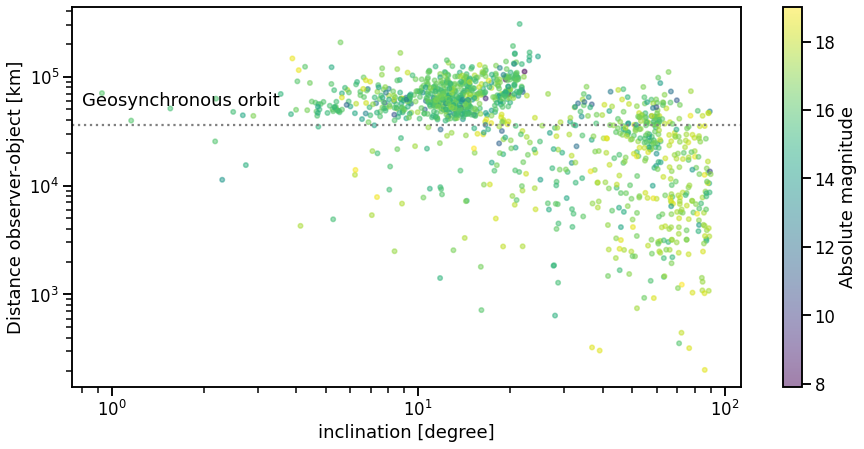

In [12]:
fig = plt.figure(figsize=(15, 7))

mask2 = np.isfinite(sizes) #* (classes == 'LEO') #* (sizes < 10)

# magapp_median = np.array([np.median(i) for i in magapp[maskSize]])
plt.scatter(
    inclination[mask2], 
    distances[mask2], 
    marker='.', 
    c=np.array([np.median(i) for i in magabs])[mask2], 
    alpha=0.5,
)
plt.xlabel(r'inclination [degree]')
plt.ylabel(r'Distance observer-object [km]')
plt.axhline(42000 - R_earth.value/1000., ls=':', color='grey')
plt.colorbar().set_label('Absolute magnitude')

plt.text(0.8, 6 * 1e4, 'Geosynchronous orbit', va='center')
plt.xscale('log')
plt.yscale('log')

## Plotting nightly data

Just change the night ID `n` to show the tracklets for one night, and remove the `set_ylim`, `set_xlim` below. We just show an interesting one below:

-------
Number of alerts: 55
velocity (deg/hour): 105.98
period (hour): 3.40
TRCK1245_00
-------
Number of alerts: 63
velocity (deg/hour): 189.51
period (hour): 1.90
TRCK1245_01
-------
Number of alerts: 11
velocity (deg/hour): 186.36
period (hour): 1.93
TRCK1245_02


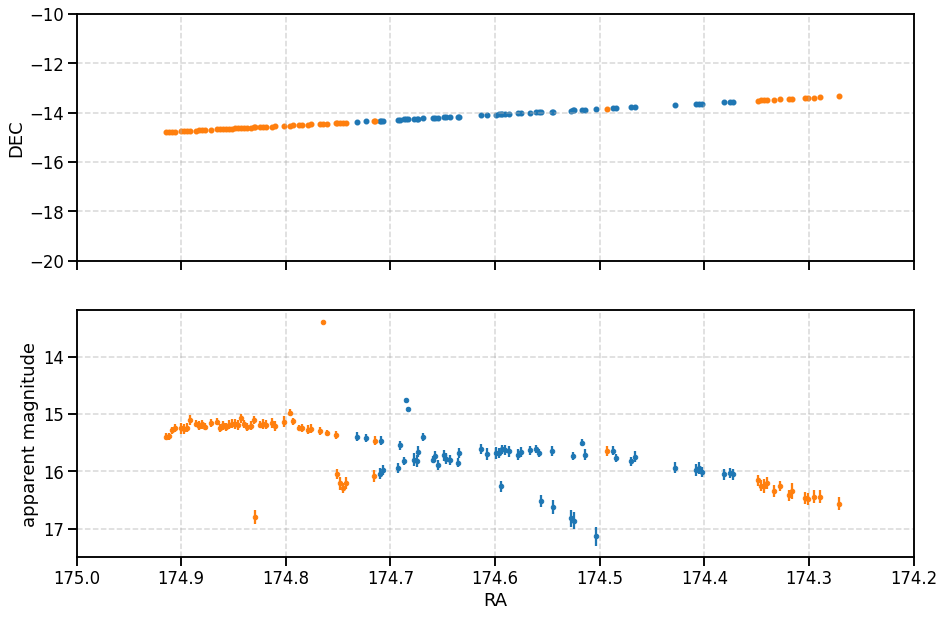

In [13]:
n = 1245

fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
maskNight = data['nid'] == n
for k in np.unique(data[maskNight]['tracklet_number']):
    maskTracklet = data['tracklet_number'] == k
    mask = maskTracklet * maskNight

    ax[0].scatter(
        data['ra'][mask], 
        data['dec'][mask], 
        marker='.'
    )

    vel = get_velocity_bystep(data[mask])
    print('-------')
    print('Number of alerts: {}'.format(np.sum(mask)))
    print('velocity (deg/hour): {:.2f}'.format(vel))
    period = 360. / vel
    print('period (hour): {:.2f}'.format(period))
    print(data[mask]['tracklet_number'][0])

    mag, err = np.array(
        [
            dc_mag(*i) for i in zip(
                data[mask]['fid'],
                data[mask]['magpsf'],
                data[mask]['sigmapsf'],
                data[mask]['magnr'],
                data[mask]['sigmagnr'],
                data[mask]['magzpsci'],
                data[mask]['isdiffpos'],
            )
        ]
    ).T

    magabs_, _ = apparent_to_absolute(
        mag, 
        data['jd'][mask][0],
        data['ra'][mask],
        data['dec'][mask],
    )

    ax[1].errorbar(
            data['ra'][mask], 
            magabs_, 
            err, 
            marker='.', ls=''
    )

ax[0].set_ylabel('DEC')
ax[0].grid(alpha=0.5, ls='--')
ax[0].set_ylim(-20, -10)

ax[1].set_xlabel('RA')
ax[1].set_ylabel('apparent magnitude')
ax[1].set_xlim(174.2, 175)

plt.gca().invert_xaxis()
ax[1].invert_yaxis()
ax[1].grid(alpha=0.5, ls='--')
plt.show()

In [14]:
def sigmoid(img: list) -> list:

    """ Sigmoid function used for img_normalizer

    Parameters
    -----------
    img: float array
        a float array representing a non-normalized image

    Returns
    -----------
    out: float array
    """

    # Compute mean and std of the image
    img_mean, img_std = img.mean(), img.std()
    # restore img to normal mean and std
    img_normalize = (img - img_mean) / img_std
    # image inversion
    inv_norm = -img_normalize
    # compute exponential of inv img
    exp_norm = np.exp(inv_norm)
    # perform sigmoid calculation and return it
    return 1 / (1 + exp_norm)

def sigmoid_normalizer(img: list, vmin: float, vmax: float) -> list:
    """ Image normalisation between vmin and vmax using Sigmoid function

    Parameters
    -----------
    img: float array
        a float array representing a non-normalized image

    Returns
    -----------
    out: float array where data are bounded between vmin and vmax
    """
    return (vmax - vmin) * sigmoid(img) + vmin
    
def add_cutout(image_data, data, pos, size, pos_, wcs, color):
    cutout = Cutout2D(image_data, pos, size, wcs=wcs)
    
    axins = ax.inset_axes(pos_)

    cutout.plot_on_original(color='white')

    # TRCK1245_00 & TRCK1245_01
    maskNight = data['nid'] == 1245
    maskTracklet = data['tracklet_number'] == 'TRCK1245_00'
    mask = maskNight * maskTracklet

    coords = SkyCoord(data['ra'][mask], data['dec'][mask], unit='deg')
    x, y = cutout.wcs.world_to_array_index(coords)
    axins.scatter(
        y, x, 
        marker='x',
        s=200,
        color='C0'
    )
    
    maskNight = data['nid'] == 1245
    maskTracklet = data['tracklet_number'] == 'TRCK1245_01'
    mask = maskNight * maskTracklet

    coords = SkyCoord(data['ra'][mask], data['dec'][mask], unit='deg')
    x, y = cutout.wcs.world_to_array_index(coords)
    axins.scatter(
        y, x, 
        marker='x',
        s=200,
        color='C1'
    )
    
    b  = sigmoid_normalizer(cutout.data, 0, 1)
    c = np.copy(b)
    m = b > 0.95
    c[m] = 0.0

    im = axins.imshow(c, cmap='gray', origin="lower")
    axins.set_xticklabels('')
    axins.set_yticklabels('')

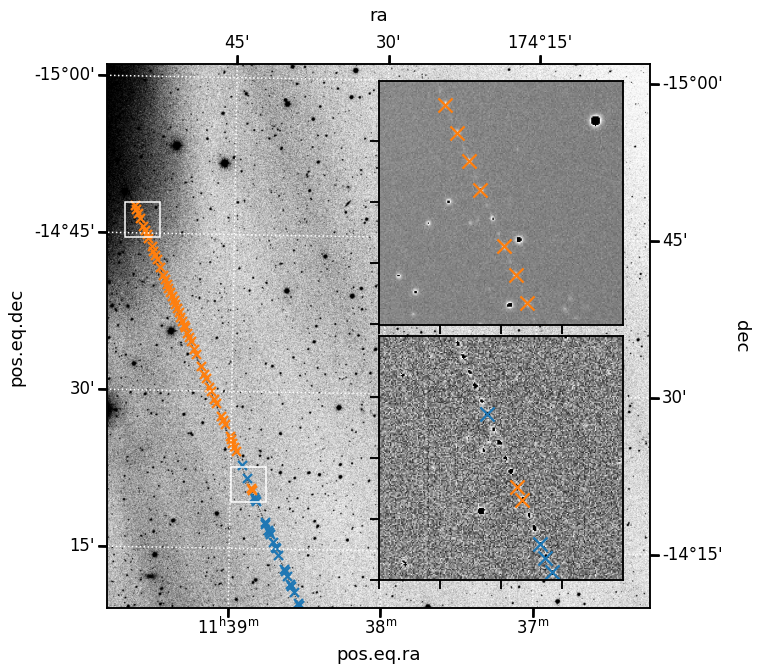

In [15]:
fig = plt.figure(figsize=(15, 10))

# wget https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2020/0530/163021/ztf_20200530163021_000318_zr_c13_o_q4_sciimg.fits
# see ZTF api
image_file = get_pkg_data_filename('ztf_20200530163021_000318_zr_c13_o_q4_sciimg.fits')
image_header = fits.open(image_file)[0].header  # extract header info
image_data = fits.getdata(image_file, ext=0)

# use the WCS class to get coordinate info and projection axes to use
wcs = WCS(image_header)

from astropy.nddata import Cutout2D
from astropy import units as u

# add the image
b  = sigmoid_normalizer(image_data, 0, 1)
c = np.copy(b)
m = b > 0.5
c[m] = 0.0

ax = fig.add_subplot(1, 1, 1, projection=wcs)

# TRCK1245_00 & TRCK1245_01
maskNight = data['nid'] == 1245
maskTracklet = data['tracklet_number'] == 'TRCK1245_00'
mask = maskNight * maskTracklet
ax.scatter(
    data['ra'][mask], 
    data['dec'][mask], 
    marker='x',
    transform=ax.get_transform('world')
)

maskNight = data['nid'] == 1245
maskTracklet = data['tracklet_number'] == 'TRCK1245_01'
mask = maskNight * maskTracklet
ax.scatter(
    data['ra'][mask], 
    data['dec'][mask], 
    marker='x',
    transform=ax.get_transform('world')
)

im = ax.imshow(c, cmap='gray', origin='lower')

##### cutout
add_cutout(image_data, data, (800, 700), (200, 200), [0.5, 0.05, 0.45, 0.45], wcs, color='C3')
add_cutout(image_data, data, (200, 2200), (200, 200), [0.5, 0.52, 0.45, 0.45], wcs, color='C3')

overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='white', ls='dotted')

This plot shows the original ZTF image data, with tracklet data by Fink overplotted (X=alerts).